# Navier - Stokes with deepXDE

In [1]:
import deepxde as dde
import torch
import matplotlib.pyplot as plt
import numpy as np
print('___________________________________')
if torch.cuda.is_available():
        print("running on GPU")
else:
        print("running on CPU")
print('device: ',torch.cuda.get_device_name())
torch.set_default_device("cuda")
print('available GPUs:' , torch.cuda.device_count())
print('current device is:',torch.cuda.current_device())

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


___________________________________
running on GPU
device:  NVIDIA GeForce RTX 3070 Laptop GPU
available GPUs: 1
current device is: 0


In [2]:
# model parameters
rho=1
mu=1
u_in=1
d=1
l=2

In [3]:
# defining the pde
def pde(x,y):
    du_x=dde.grad.jacobian(y,x,i=0,j=0)
    du_y=dde.grad.jacobian(y,x,i=0,j=1)
    dv_x=dde.grad.jacobian(y,x,i=1,j=0)
    dv_y=dde.grad.jacobian(y,x,i=1,j=1)
    dp_x=dde.grad.jacobian(y,x,i=2,j=0)
    dp_y=dde.grad.jacobian(y,x,i=2,j=1)

    du_xx=dde.grad.hessian(y,x,component=0,i=0,j=0)
    du_yy=dde.grad.hessian(y,x,component=0,i=1,j=1)
    dv_xx=dde.grad.hessian(y,x,component=1,i=0,j=0)
    dv_yy=dde.grad.hessian(y,x,component=1,i=1,j=1)

    pde_u= y[:,0:1]*du_x + y[:,1:2]*du_y + 1/rho * dp_x -(mu/rho)*(du_xx+du_yy)
    pde_v= y[:,0:1]*dv_x + y[:,1:2]*dv_y + 1/rho * dp_y -(mu/rho)*(dv_xx+dv_yy)
    pde_cont= du_x+dv_y

    return [pde_u , pde_v , pde_cont]

In [4]:
# computational domain (we are solving on steady state)
geom=dde.geometry.Rectangle(xmin=[-1, 0], xmax=[1, 1])

In [5]:
# defining the boundary geometry
def boundary_wall(x , on_boundary):
    return on_boundary and (dde.utils.isclose(x[1] , 0) or dde.utils.isclose(x[1] , 1))

def boundary_inlet(x,on_boundary):
    return on_boundary and dde.utils.isclose(x[0] , -1)

def boundary_outlet(x,on_boundary):
    return on_boundary and dde.utils.isclose(x[0] , 1)

In [6]:
# defining the boundary condition
bc_wall_u=dde.DirichletBC(geom,lambda x:0 , boundary_wall , component=0)
bc_wall_v=dde.DirichletBC(geom,lambda x:0 , boundary_wall , component=1)

bc_inlet_u=dde.DirichletBC(geom,lambda x:1 , boundary_inlet , component=0)
bc_inlet_v=dde.DirichletBC(geom,lambda x:0 , boundary_inlet , component=1)

bc_outlet_p=dde.DirichletBC(geom,lambda x:0 , boundary_outlet , component=2)
bc_outlet_v=dde.DirichletBC(geom,lambda x:0 , boundary_outlet , component=1)

boundaries= [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v]

In [16]:
data = dde.data.PDE(geom, pde , boundaries , num_domain=4000 , num_boundary=400  ,num_test=1000)

In [17]:
net = dde.nn.FNN([2]+[64]*5+[3] , 'tanh' , 'Glorot uniform')
model=dde.Model(data , net)

In [18]:
model.compile('adam' , lr=1e-3)
losshistory , train_state = model.train(epochs=10000)

Compiling model...
'compile' took 0.000214 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.92e-01, 1.22e-01, 2.75e-03, 6.66e-02, 2.15e-02, 6.58e-01, 7.00e-02, 2.02e-02, 4.23e-02]    [1.99e-01, 1.23e-01, 2.82e-03, 6.66e-02, 2.15e-02, 6.58e-01, 7.00e-02, 2.02e-02, 4.23e-02]    []  
1000      [9.53e-04, 6.37e-04, 8.42e-03, 3.11e-02, 1.29e-02, 3.86e-02, 2.39e-03, 8.25e-04, 1.42e-05]    [5.98e-04, 4.60e-04, 5.68e-03, 3.11e-02, 1.29e-02, 3.86e-02, 2.39e-03, 8.25e-04, 1.42e-05]    []  
2000      [2.32e-03, 4.07e-04, 4.35e-03, 2.17e-02, 1.07e-02, 3.77e-02, 5.44e-04, 4.88e-04, 6.16e-05]    [1.54e-03, 2.89e-04, 2.21e-03, 2.17e-02, 1.07e-02, 3.77e-02, 5.44e-04, 4.88e-04, 6.16e-05]    []  
3000      [4.28e-03, 2.53e-03, 3.21e-03, 2.03e-02, 9.38e-03, 2.68e-02, 1.74e-03, 2.85e-04, 9.42e-05]    [3.16e-03, 2

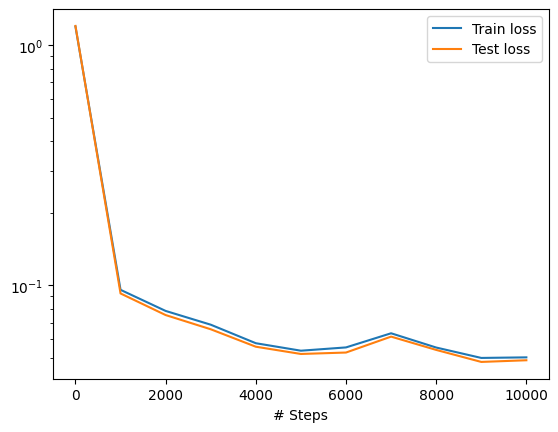

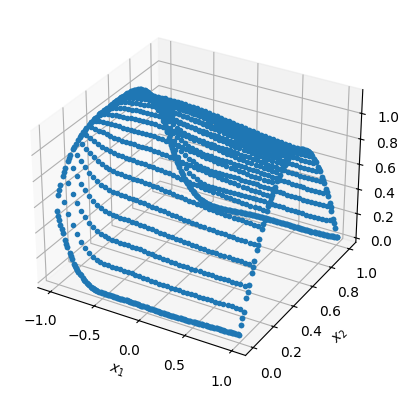

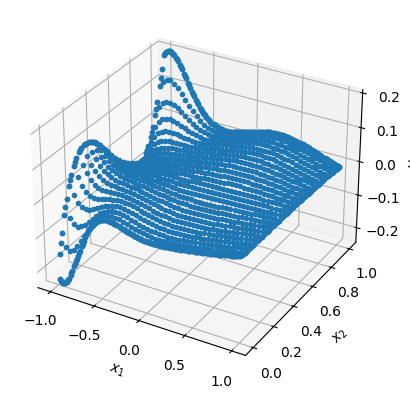

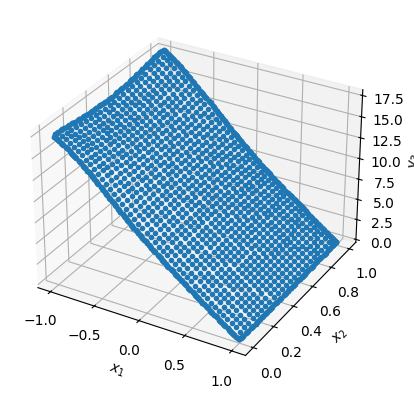

In [19]:
dde.saveplot(losshistory,train_state,isplot=True,issave=False)

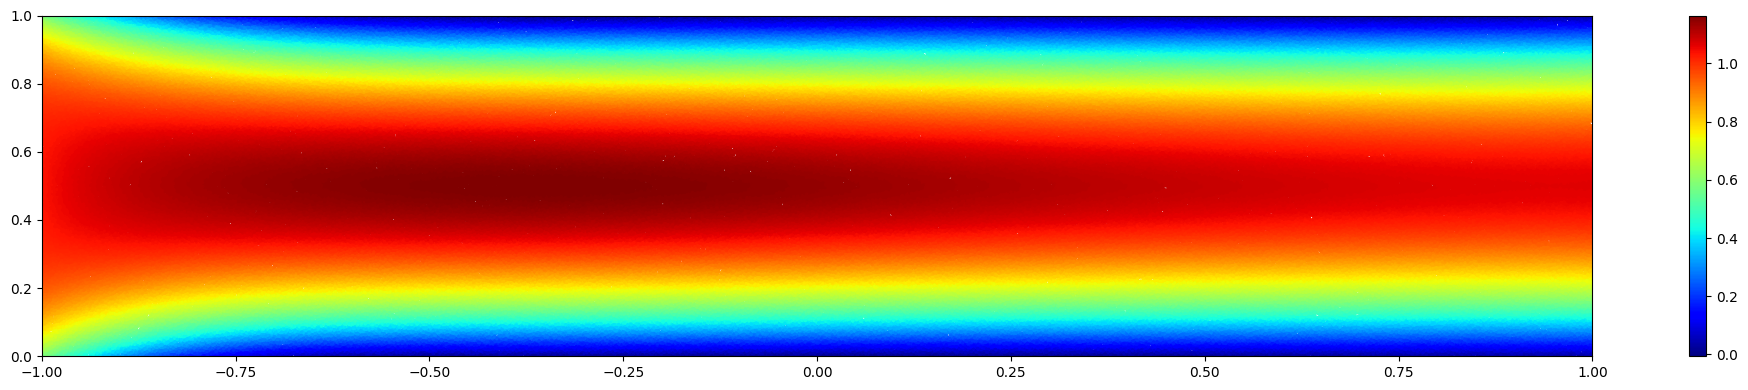

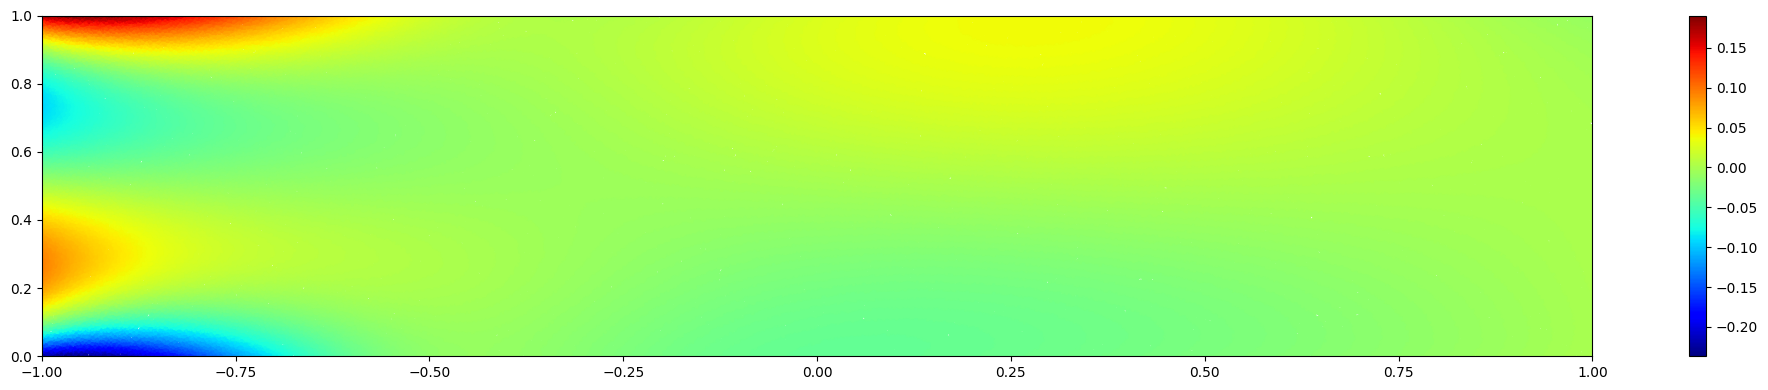

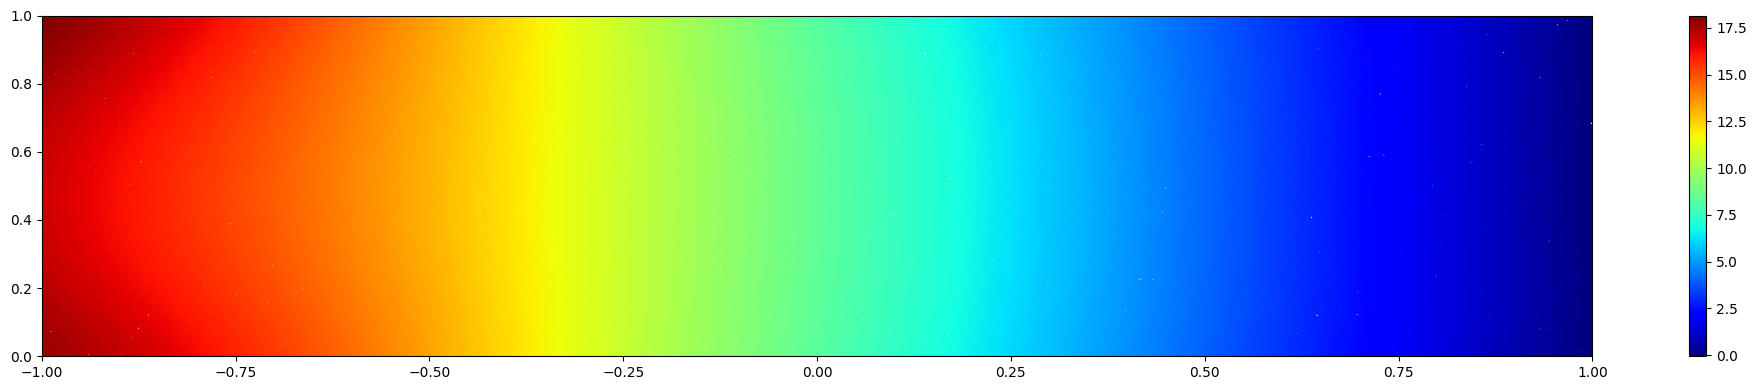

In [20]:
samples=geom.random_points(500000)
result=model.predict(samples)

color_legend=[[0,1] , [-0.3,0.3] , [0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0], samples[:,1] , c=result[:,idx], cmap='jet' , s=2)
    plt.colorbar()
    #plt.clim(color_legend[idx])
    plt.xlim((-1,1))
    plt.ylim((0,1))
    plt.tight_layout()
    string='plot num'+str(idx+1)
    #plt.savefig(string)
    plt.show()